In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries and Functions Used

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from scipy.io import loadmat
import io
import cv2
import joblib
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
# import wfdb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks 
from imblearn.over_sampling import RandomOverSampler, SMOTE
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, BatchNormalization, Flatten, Dense
from keras.layers import MaxPool2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers.merge import concatenate
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.utils import np_utils
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras import regularizers
import random

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.color import rgb2gray
from scipy.ndimage import zoom
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import requests
from keras.utils import np_utils

In [ ]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
haar_cascade_face = cv2.CascadeClassifier('/content/drive/MyDrive/IR/Face_Detection.xml')

In [ ]:
def detect_faces(cascade, test_image, scaleFactor = 1.1, width=5):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()
    
    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    
    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    h1 = 0
    w1 = 0
    for (x, y, w, h) in faces_rect:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (255, 255, 0), width)
        h1 = h
        w1 = w
        break
    crop_img = image_copy[y+width:y+h1-width, x+width:x+w1-width]
    
    return crop_img, image_copy

In [ ]:
X_test = joblib.load('/content/drive/MyDrive/IR/IR_Project/IR_testing_data')
y_test = joblib.load('/content/drive/MyDrive/IR/IR_Project/IR_testing_label')

# ***Emotion Recognition***

## Model for 4 classes

In [ ]:
model = load_model('/content/drive/MyDrive/IR/IR_Project/ModelOn4.h5')

In [ ]:
def predict_emotion(model, image):
  # emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}
  emotions = {0:'angry', 1:'happy', 2:'neutral', 3:'sad'}
  # plt.imshow(image.reshape(48, 48))
  # print('Original Emotion: ',emotions[original_label])
  predictions = model.predict(image.reshape(1, 48, 48, 1))
  y_pred = np.argmax(predictions)
  emo = emotions[y_pred]
  intensity = np.max(predictions)
  print('Predicted Emotion: ', emo)
  print('Intensity Of Emotion: {0:.3f}%'.format(intensity*100))
  return emo, intensity

Predicted Emotion:  angry
Intensity Of Emotion: 99.217%


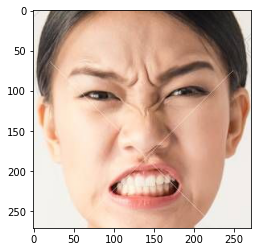

In [ ]:
url = 'https://i.pinimg.com/originals/d7/fb/39/d7fb39ea4b7aeff161b14e8238b553d6.jpg'
img = Image.open(requests.get(url, stream=True).raw)
image = np.array(img)
faces, original = detect_faces(haar_cascade_face, image, width=1)
plt.imshow(faces)
image = cv2.resize(faces, dsize=(48, 48))
image = image[:, :, 2]
emotion, intensity= predict_emotion(model, image)

## Predictions using ensemble models (5 Classes)

In [ ]:
happy_mdl = load_model('/content/drive/MyDrive/IR/IR_Project/HappyModel.h5')
sad_mdl = load_model('/content/drive/MyDrive/IR/IR_Project/SadModel.h5')
angry_mdl = load_model('/content/drive/MyDrive/IR/IR_Project/AngryModel.h5')
neutral_mdl = load_model('/content/drive/MyDrive/IR/IR_Project/NeutralModel.h5')
surprise_mdl = load_model('/content/drive/MyDrive/IR/IR_Project/SurpriseModel.h5')

In [ ]:
def predict_emotion_ensemble(image):
  
  emotions = {0:'angry', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}
  # plt.imshow(image.reshape(48, 48))
  # print('Original Emotion: ',emotions[original_label])
  prob_emo = 0
  emo = 'None'
  predictions = neutral_mdl.predict(image.reshape(1, 48, 48, 1))[0, 1]
  # print('Neutral', predictions)
  if prob_emo < predictions:
    emo = 'neutral'
    prob_emo = predictions
  predictions = sad_mdl.predict(image.reshape(1, 48, 48, 1))[0, 1]
  # print('Sad', predictions)
  if prob_emo < predictions:
    emo = 'sad'
    prob_emo = predictions
  predictions = angry_mdl.predict(image.reshape(1, 48, 48, 1))[0, 1]
  # print('Angry', predictions)
  if prob_emo < predictions:
    emo = 'angry'
    prob_emo = predictions
  predictions = happy_mdl.predict(image.reshape(1, 48, 48, 1))[0, 1]
  # print('Happy', predictions)
  if prob_emo < predictions:
    emo = 'happy'
    prob_emo = predictions
  
  predictions = surprise_mdl.predict(image.reshape(1, 48, 48, 1))[0, 1]
  # print('Surprise', predictions)
  if prob_emo < predictions:
    emo = 'surprise'
    prob_emo = predictions
  # emo = emotions[original_label]
  print('Predicted Emotion: ', emo)
  print('Intensity Of Emotion: {0:.3f}%'.format(prob_emo*100))
  return emo, prob_emo

Predicted Emotion:  surprise
Intensity Of Emotion: 96.678%


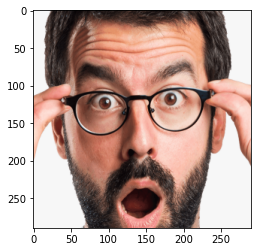

In [ ]:
url = 'https://www.pngitem.com/pimgs/m/532-5328769_surprised-man-no-background-hd-png-download.png'
img = Image.open(requests.get(url, stream=True).raw)
image = np.array(img)
faces, original = detect_faces(haar_cascade_face, image, width=1)
plt.imshow(faces)
image = cv2.resize(faces, dsize=(48, 48))
image = image[:, :, 2]
emotion, intensity = predict_emotion_ensemble(image)

## Model for 7 classes

In [ ]:
model = load_model('/content/drive/MyDrive/IR/IR_Project/Model2.h5')

In [ ]:
def predict_emotion(model, image):
  emotions = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'sad', 6:'surprise'}
  predictions = model.predict(image.reshape(1, 48, 48, 1))
  y_pred = np.argmax(predictions)
  emo = emotions[y_pred]
  intensity = np.max(predictions)
  print('Predicted Emotion: ', emo)
  print('Intensity Of Emotion: {0:.3f}%'.format(intensity*100))
  return emo, intensity

Predicted Emotion:  angry
Intensity Of Emotion: 87.829%


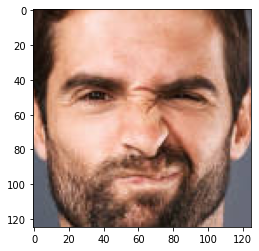

In [ ]:
url = 'https://media.istockphoto.com/photos/mmmnah-picture-id1080813354?k=6&m=1080813354&s=612x612&w=0&h=U5lUEmEvw0qKVnB6QvNnsHZA9Ic2kjQN8Rl8QirZqNg='
img = Image.open(requests.get(url, stream=True).raw)
image = np.array(img)
faces, original = detect_faces(haar_cascade_face, image, width=1)
plt.imshow(faces)
image = cv2.resize(faces, dsize=(48, 48))
image = image[:, :, 2]
emotion, intensity= predict_emotion(model, image)

# ***Music Recommendation***

In [ ]:
google_sheet_id = '1AmlOC6RN-pYKdU6nU2e2dmxXPYhJGc3zWknkKQFt9O4'
worksheetname = 'IR_Playlist_Data'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(google_sheet_id, worksheetname)

In [ ]:
data = pd.read_csv(URL)

In [ ]:
playlist = data.iloc[:, :].values

Emotion to Genre Mappings

In [ ]:
mappings = {
    0: ['Instrumental', 'Classical', 'Ballad'],
    1: ['Ballad', 'Instrumental', 'Rock'],
    2: ['EDM', 'Jazz', 'Rock', 'Pop'],
    3: ['Pop', 'Rock', 'EDM', 'Blues', 'Hip Hop'],
    4: ['Classical', 'Instrumental', 'Ballad'],
    5: ['Folk', 'Rock', 'Pop'],
    6: ['EDM', 'Rock', 'Jazz']
}

Suggestions based on emotion detected

In [ ]:
def suggest(emotion, intensity):
  emotions = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'surprise':6}
  emotion_label = emotions[emotion]
  list_data = []
  genres = playlist[:, 2]
  i = 0
  if intensity > 0.35 and intensity < 0.65:
    i=0
  elif intensity >= 0.65 and intensity < 0.85:
    i=1
  else:
    i=2
  i = mappings[emotion_label][i]
  for j in range(len(genres)):
    if genres[j] == i:
      list_data.append(playlist[j])
  random.shuffle(list_data)
  print('We suggest you this playlist:', list_data[0][1])
  print('Genre:', list_data[0][2])
  print('Artist:', list_data[0][3])
  print('Language:', list_data[0][4])

In [ ]:
n = random.randint(0, 7000)
emotion, intensity = predict_emotion(model, X_test[n])
plt.imshow(X_test[n].reshape(48, 48))
suggest(emotion, intensity)

In [ ]:
suggest(emotion, intensity)

We suggest you this playlist: https://gaana.com/playlist/gaana-dj-atif-aslam-romantic-hits
Genre: Ballad
Artist: Atif Aslam
Language: Hindi


# ***Real Time Images and Running the system***

In [ ]:
def detect_faces_emotion(cascade, test_image, scaleFactor = 1.1, width=5):

    original = test_image.copy()
    
    gray_image = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    h1 = 0
    w1 = 0
    for (x, y, w, h) in faces_rect:
        cv2.rectangle(original, (x, y), (x+w, y+h), (255, 255, 0), width)
        h1 = h
        w1 = w
        break
    faces = original[y+width:y+h1-width, x+width:x+w1-width]
    image = cv2.resize(faces, dsize=(48, 48))
    image = image[:, :, 2]
    emotion, intensity = predict_emotion_ensemble(image)
    check = cv2.putText(original, emotion, (int(x)+80, int(y)-20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(convertToRGB(check))
    return emotion, intensity

Predicted Emotion:  happy
Intensity Of Emotion: 99.710%
We suggest you this playlist: https://youtube.com/playlist?list=RDCLAK5uy_nlOMew8qv8HGXb9HbshuU1OgH3aL_JMKA
Genre: EDM
Artist: Multiple
Language: Punjabi


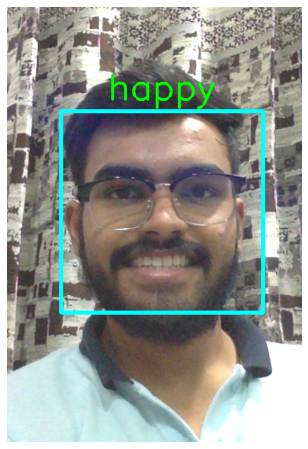

In [ ]:
image = cv2.imread('/content/HappyTest.png')
emotion, intensity = detect_faces_emotion(haar_cascade_face, image)
suggest(emotion, intensity)

Predicted Emotion:  neutral
Intensity Of Emotion: 60.147%
We suggest you this playlist: https://youtu.be/595RXHlTcWc
Genre: Classical
Artist: Lata Mangeshkar
Language: Hindi


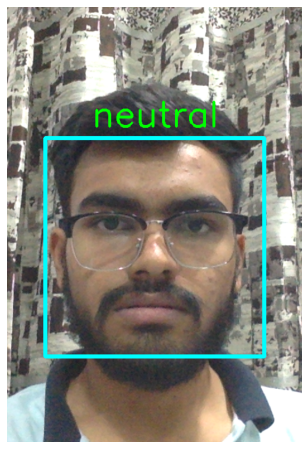

In [ ]:
image = cv2.imread('/content/NeutralTest.png')
emotion, intensity = detect_faces_emotion(haar_cascade_face, image)
suggest(emotion, intensity)

Predicted Emotion:  surprise
Intensity Of Emotion: 36.622%
We suggest you this playlist: https://youtube.com/playlist?list=RDCLAK5uy_nlOMew8qv8HGXb9HbshuU1OgH3aL_JMKA
Genre: EDM
Artist: Multiple
Language: Punjabi


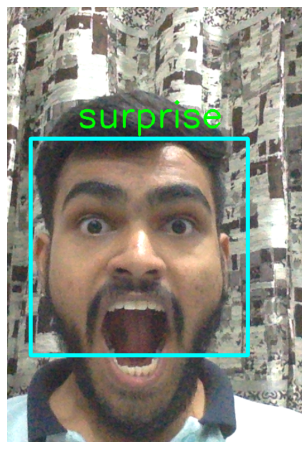

In [ ]:
image = cv2.imread('/content/SurpriseTest.png')
emotion, intensity = detect_faces_emotion(haar_cascade_face, image)
suggest(emotion, intensity)

Predicted Emotion:  angry
Intensity Of Emotion: 66.289%
We suggest you this playlist: https://www.youtube.com/playlist?list=PLSJZjlTMaBmamEFxsl8fU_x36NpIT71Yx
Genre: Classical
Artist: Sonu Nigam
Language: Hindi


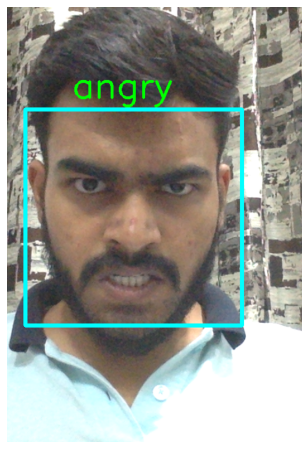

In [ ]:
image = cv2.imread('/content/AngryTest.png')
emotion, intensity = detect_faces_emotion(haar_cascade_face, image)
suggest(emotion, intensity)

Predicted Emotion:  sad
Intensity Of Emotion: 89.807%
We suggest you this playlist: https://youtu.be/zLB0vicG38I
Genre: Pop
Artist: Multiple
Language: English


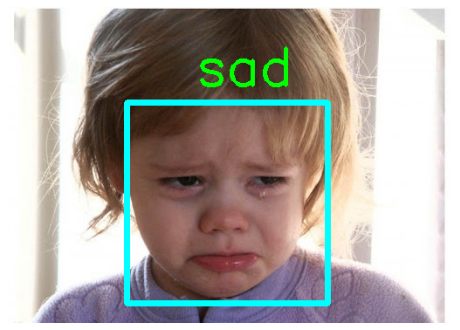

In [ ]:
image = cv2.imread('/content/SadTest.jpeg')
emotion, intensity = detect_faces_emotion(haar_cascade_face, image)
suggest(emotion, intensity)